In [28]:
# Cell 1: Imports and Setup
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, models  # Added for ResNet50
from PIL import Image
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [29]:
# Cell 3: Define ResNet18 Model (Updated for More Fine-Tuning)
import torch.nn as nn
from torchvision import models

def get_resnet18(num_classes=4):
    # Load pre-trained ResNet18
    model = models.resnet18(pretrained=True)
    
    # Freeze all layers initially
    for param in model.parameters():
        param.requires_grad = False
    
    # Unfreeze the final residual block (layer4) and the fully connected layer
    for param in model.layer4.parameters():
        param.requires_grad = True
    for param in model.fc.parameters():
        param.requires_grad = True
    
    # Replace the final fully connected layer for 4-class classification
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    
    return model.to(device)

In [30]:
# Cell 4: Define Custom Dataset (Updated to Preload Images)
class GaitGAFDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        # Preload images into memory
        print("Preloading images into memory...")
        self.images = []
        for img_path in tqdm(image_paths, desc="Loading images"):
            image = Image.open(img_path).convert('RGB')
            self.images.append(image)
        print(f"Loaded {len(self.images)} images into memory.")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

In [31]:
# Cell 5: Create Dataset Mapping for Training
import os
import glob

# Define label mapping
label_mapping = {
    "als": 0,
    "control": 1,
    "hunt": 2,
    "park": 3
}

# Base directory
base_dir = os.path.join(os.getcwd(), "gait-in-neurodegenerative-disease-database-1.0.0", "gaf_images_augmented")

# Collect image paths and labels
dataset_mapping = []
groups = ["als", "control", "hunt", "park"]
feature_columns = [
    "L_Stride", "R_Stride", "L_Swing", "R_Swing", "L_Swing%", "R_Swing%", 
    "L_Stance", "R_Stance", "L_Stance%", "R_Stance%", "DoubleSupport", "DoubleSupport%"
]

print("Creating dataset mapping for training...")
for group in groups:
    label = label_mapping[group]
    for feature in feature_columns:
        feature_dir = os.path.join(base_dir, group, feature)
        if not os.path.exists(feature_dir):
            print(f"Warning: Directory not found: {feature_dir}")
            continue
        
        # Find all .png files in the feature directory
        image_paths = glob.glob(os.path.join(feature_dir, "*.png"))
        for image_path in image_paths:
            dataset_mapping.append((image_path, label))
        
        print(f"Collected {len(image_paths)} images for {group}/{feature}")

# Verify total images
print(f"\nTotal images in dataset: {len(dataset_mapping)} (expected 3072)")
if len(dataset_mapping) != 3072:
    print(f"Warning: Expected 3072 images (64 subjects × 12 features × 4 versions), but found {len(dataset_mapping)}.")

# Example entry
if dataset_mapping:
    print(f"Example entry: {dataset_mapping[0]}")

Creating dataset mapping for training...
Collected 52 images for als/L_Stride
Collected 52 images for als/R_Stride
Collected 52 images for als/L_Swing
Collected 52 images for als/R_Swing
Collected 52 images for als/L_Swing%
Collected 52 images for als/R_Swing%
Collected 52 images for als/L_Stance
Collected 52 images for als/R_Stance
Collected 52 images for als/L_Stance%
Collected 52 images for als/R_Stance%
Collected 52 images for als/DoubleSupport
Collected 52 images for als/DoubleSupport%
Collected 64 images for control/L_Stride
Collected 64 images for control/R_Stride
Collected 64 images for control/L_Swing
Collected 64 images for control/R_Swing
Collected 64 images for control/L_Swing%
Collected 64 images for control/R_Swing%
Collected 64 images for control/L_Stance
Collected 64 images for control/R_Stance
Collected 64 images for control/L_Stance%
Collected 64 images for control/R_Stance%
Collected 64 images for control/DoubleSupport
Collected 64 images for control/DoubleSupport%
C

In [32]:
# Cell 6: Prepare Dataset and DataLoader (Updated for Data Augmentation)
from sklearn.model_selection import train_test_split
from collections import Counter
import torch
from torchvision import transforms

# Extract image paths and labels from dataset_mapping (from Cell 5)
image_paths = [item[0] for item in dataset_mapping]
labels = [item[1] for item in dataset_mapping]

# Split dataset into train, validation, and test sets (70% train, 10% val, 20% test)
train_val_paths, test_paths, train_val_labels, test_labels = train_test_split(
    image_paths, labels, test_size=0.2, stratify=labels, random_state=42
)
train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_val_paths, train_val_labels, test_size=0.1/0.8, stratify=train_val_labels, random_state=42
)

# Define transforms with augmentation for training
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip images horizontally
    transforms.RandomRotation(degrees=10),   # Randomly rotate images by up to 10 degrees
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define transforms without augmentation for validation and test
val_test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets with appropriate transforms
train_dataset = GaitGAFDataset(train_paths, train_labels, transform=train_transform)
val_dataset = GaitGAFDataset(val_paths, val_labels, transform=val_test_transform)
test_dataset = GaitGAFDataset(test_paths, test_labels, transform=val_test_transform)

# Compute class weights for WeightedRandomSampler (to handle class imbalance)
label_counts = Counter(train_labels)
num_samples = len(train_labels)
class_weights = {i: num_samples / (len(label_counts) * count) for i, count in label_counts.items()}
sample_weights = [class_weights[label] for label in train_labels]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

# Create DataLoaders with optimized settings
batch_size = 64  # Kept as is
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, sampler=sampler, num_workers=0, pin_memory=True
)
val_loader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True
)
test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True
)

# Print dataset sizes and class distributions
print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")
print(f"Training class distribution: {Counter(train_labels)}")
print(f"Validation class distribution: {Counter(val_labels)}")
print(f"Test class distribution: {Counter(test_labels)}")

Preloading images into memory...


Loading images:   0%|          | 0/2149 [00:00<?, ?it/s]

Loaded 2149 images into memory.
Preloading images into memory...


Loading images:   0%|          | 0/308 [00:00<?, ?it/s]

Loaded 308 images into memory.
Preloading images into memory...


Loading images:   0%|          | 0/615 [00:00<?, ?it/s]

Loaded 615 images into memory.
Training dataset size: 2149
Validation dataset size: 308
Test dataset size: 615
Training class distribution: Counter({2: 672, 1: 537, 3: 504, 0: 436})
Validation class distribution: Counter({2: 96, 1: 77, 3: 72, 0: 63})
Test class distribution: Counter({2: 192, 1: 154, 3: 144, 0: 125})


In [24]:
# Cell 6: Prepare Dataset and DataLoader
from sklearn.model_selection import train_test_split
from collections import Counter
import torch
from torchvision import transforms

# Extract image paths and labels from dataset_mapping (from Cell 5)
image_paths = [item[0] for item in dataset_mapping]
labels = [item[1] for item in dataset_mapping]

# Split dataset into train, validation, and test sets (70% train, 10% val, 20% test)
train_val_paths, test_paths, train_val_labels, test_labels = train_test_split(
    image_paths, labels, test_size=0.2, stratify=labels, random_state=42
)
train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_val_paths, train_val_labels, test_size=0.1/0.8, stratify=train_val_labels, random_state=42
)

# Define transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = GaitGAFDataset(train_paths, train_labels, transform=transform)
val_dataset = GaitGAFDataset(val_paths, val_labels, transform=transform)
test_dataset = GaitGAFDataset(test_paths, test_labels, transform=transform)

# Compute class weights for WeightedRandomSampler (to handle class imbalance)
label_counts = Counter(train_labels)
num_samples = len(train_labels)
class_weights = {i: num_samples / (len(label_counts) * count) for i, count in label_counts.items()}
sample_weights = [class_weights[label] for label in train_labels]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

# Create DataLoaders with optimized settings
batch_size = 16  # Increased to better utilize GPU
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, sampler=sampler, num_workers=0, pin_memory=True
)
val_loader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True
)
test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True
)

# Print dataset sizes and class distributions
print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")
print(f"Training class distribution: {Counter(train_labels)}")
print(f"Validation class distribution: {Counter(val_labels)}")
print(f"Test class distribution: {Counter(test_labels)}")

Preloading images into memory...


Loading images:   0%|          | 0/2149 [00:00<?, ?it/s]

Loaded 2149 images into memory.
Preloading images into memory...


Loading images:   0%|          | 0/308 [00:00<?, ?it/s]

Loaded 308 images into memory.
Preloading images into memory...


Loading images:   0%|          | 0/615 [00:00<?, ?it/s]

Loaded 615 images into memory.
Training dataset size: 2149
Validation dataset size: 308
Test dataset size: 615
Training class distribution: Counter({2: 672, 1: 537, 3: 504, 0: 436})
Validation class distribution: Counter({2: 96, 1: 77, 3: 72, 0: 63})
Test class distribution: Counter({2: 192, 1: 154, 3: 144, 0: 125})


In [33]:
# Cell 7: Training and Evaluation Functions (Updated for Metrics Tracking)
from torch.amp import autocast, GradScaler  # Updated API

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    scaler = GradScaler('cuda')  # Updated API: Specify device
    best_val_f1 = 0.0
    best_model_state = None  # To store the best model state in memory
    
    # Lists to store metrics for plotting
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    train_f1s = []
    val_f1s = []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        train_preds = []
        train_true = []
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            with autocast('cuda'):  # Updated API: Specify device
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            train_preds.extend(preds.tolist())
            train_true.extend(labels.tolist())
        epoch_loss = running_loss / len(train_loader.dataset)
        train_accuracy = accuracy_score(train_true, train_preds)
        train_precision, train_recall, train_f1, _ = precision_recall_fscore_support(
            train_true, train_preds, average='weighted', zero_division=0
        )

        # Validation
        model.eval()
        val_preds = []
        val_true = []
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                with autocast('cuda'):  # Updated API: Specify device
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_preds.extend(preds.tolist())
                val_true.extend(labels.tolist())
        val_loss = val_loss / len(val_loader.dataset)
        val_accuracy = accuracy_score(val_true, val_preds)
        val_precision, val_recall, val_f1, _ = precision_recall_fscore_support(
            val_true, val_preds, average='weighted', zero_division=0
        )

        # Store metrics
        train_losses.append(epoch_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        train_f1s.append(train_f1)
        val_f1s.append(val_f1)

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train - Loss: {epoch_loss:.4f}, Accuracy: {train_accuracy:.4f}, F1: {train_f1:.4f}")
        print(f"Val   - Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}, F1: {val_f1:.4f}")
        print(f"Unique predicted classes (val): {np.unique(val_preds)}")

        # Update best model state if validation F1-score improves
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_model_state = model.state_dict()  # Store the state in memory

    # Return the best model state and collected metrics
    return best_model_state, {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies,
        'train_f1s': train_f1s,
        'val_f1s': val_f1s
    }

def evaluate_model(model, test_loader, device):
    model.eval()
    preds = []
    true = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            with autocast('cuda'):  # Updated API: Specify device
                outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            preds.extend(predicted.tolist())
            true.extend(labels.tolist())

    accuracy = accuracy_score(true, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        true, preds, average='weighted', zero_division=0
    )
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test Precision: {precision:.4f}")
    print(f"Test Recall: {recall:.4f}")
    print(f"Test F1-Score: {f1:.4f}")
    print(f"Unique predicted classes (test): {np.unique(preds)}")

    # Confusion Matrix
    cm = confusion_matrix(true, preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['ALS', 'Control', 'Huntington', 'Parkinson'],
                yticklabels=['ALS', 'Control', 'Huntington', 'Parkinson'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix - ResNet50')
    plt.show()

c:\Users\piyus\mlenv\gaitenv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\piyus\mlenv\gaitenv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/20
Train - Loss: 0.9441, Accuracy: 0.6208, F1: 0.6193
Val   - Loss: 1.0608, Accuracy: 0.5974, F1: 0.5901
Unique predicted classes (val): [0 1 2 3]
Epoch 2/20
Train - Loss: 0.4376, Accuracy: 0.8404, F1: 0.8402
Val   - Loss: 0.5600, Accuracy: 0.7630, F1: 0.7588
Unique predicted classes (val): [0 1 2 3]
Epoch 3/20
Train - Loss: 0.2683, Accuracy: 0.8967, F1: 0.8965
Val   - Loss: 0.6497, Accuracy: 0.7792, F1: 0.7818
Unique predicted classes (val): [0 1 2 3]
Epoch 4/20
Train - Loss: 0.1998, Accuracy: 0.9288, F1: 0.9287
Val   - Loss: 0.4279, Accuracy: 0.8279, F1: 0.8253
Unique predicted classes (val): [0 1 2 3]
Epoch 5/20
Train - Loss: 0.1310, Accuracy: 0.9530, F1: 0.9530
Val   - Loss: 0.3856, Accuracy: 0.8604, F1: 0.8603
Unique predicted classes (val): [0 1 2 3]
Epoch 6/20
Train - Loss: 0.1111, Accuracy: 0.9595, F1: 0.9594
Val   - Loss: 0.3650, Accuracy: 0.8506, F1: 0.8471
Unique predicted classes (val): [0 1 2 3]
Epoch 7/20
Train - Loss: 0.1050, Accuracy: 0.9632, F1: 0.9632
Val   - 

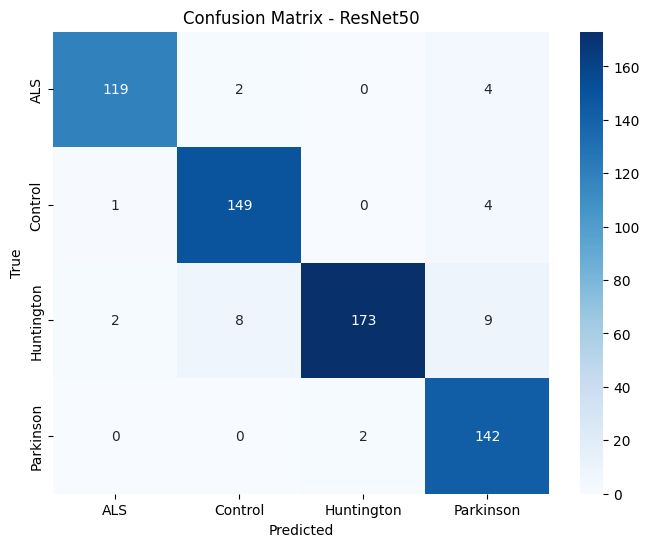

In [34]:
# Cell 8: Main Execution (Train and Evaluate ResNet18)
# Initialize model
model = get_resnet18(num_classes=4)

# Class weights for imbalanced dataset (based on training set distribution)
class_weights = torch.tensor([1.231, 1.000, 0.799, 1.066], dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Optimizer
learning_rate = 0.001  # Increased from 0.0001 for faster convergence
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

# Training parameters
num_epochs = 20  # Reduced for faster iteration

# Train model and get the best model state and metrics
best_model_state, metrics = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device)

# Load the best model state and evaluate
model.load_state_dict(best_model_state)
evaluate_model(model, test_loader, device)

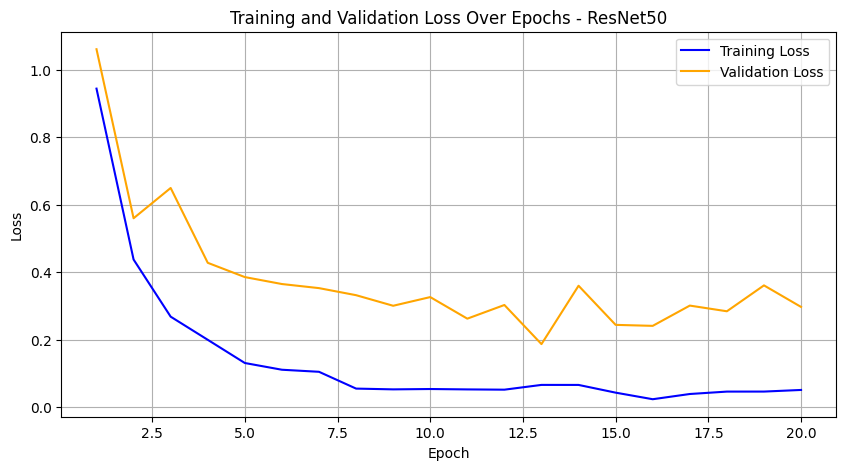

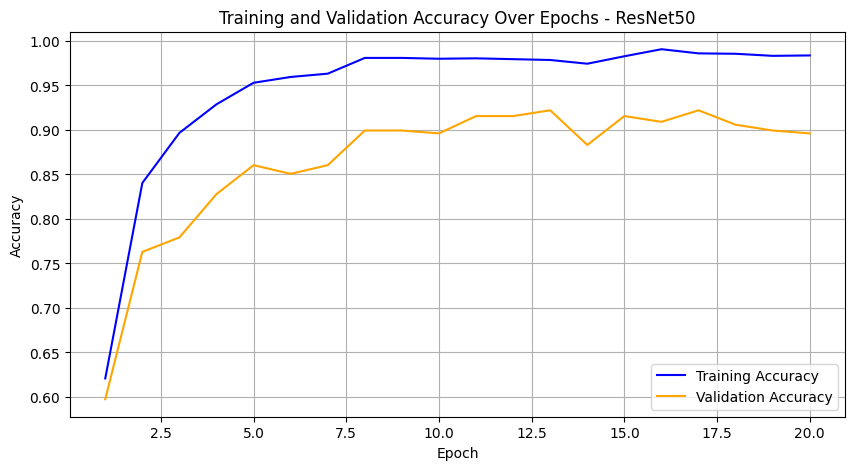

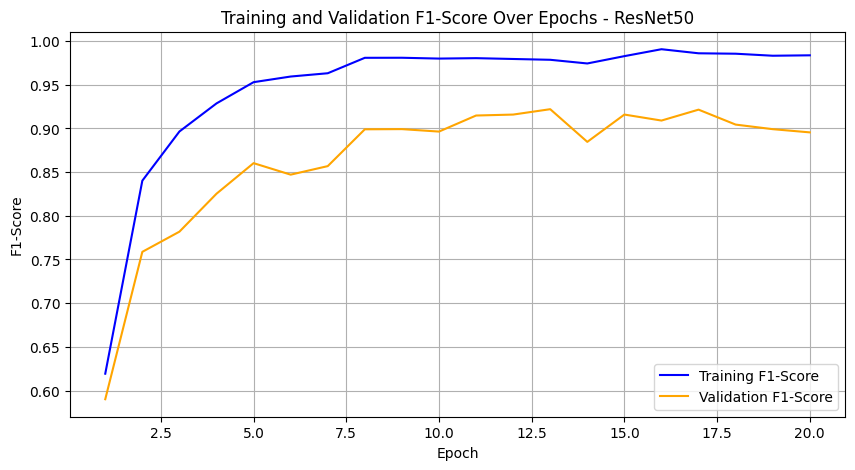

In [35]:
# Cell 9: Plot Performance Curves
# Extract metrics
train_losses = metrics['train_losses']
val_losses = metrics['val_losses']
train_accuracies = metrics['train_accuracies']
val_accuracies = metrics['val_accuracies']
train_f1s = metrics['train_f1s']
val_f1s = metrics['val_f1s']
epochs = range(1, len(train_losses) + 1)

# Plot Loss Curves
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Training Loss', color='blue')
plt.plot(epochs, val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs - ResNet50')
plt.legend()
plt.grid(True)
plt.show()

# Plot Accuracy Curves
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracies, label='Training Accuracy', color='blue')
plt.plot(epochs, val_accuracies, label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs - ResNet50')
plt.legend()
plt.grid(True)
plt.show()

# Plot F1-Score Curves
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_f1s, label='Training F1-Score', color='blue')
plt.plot(epochs, val_f1s, label='Validation F1-Score', color='orange')
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.title('Training and Validation F1-Score Over Epochs - ResNet50')
plt.legend()
plt.grid(True)
plt.show()